# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from inf5860.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The code uses a traning set, validation set, test set. The small development set is not not necessarily used)

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'inf5860/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data to use the split the training data into a training and a validation subset
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **inf5860/classifiers/softmax.py**. 
The loss for one sample is 
$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in}$

You should sum over all samples

In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file inf5860/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from inf5860.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.361073
sanity check: 2.302585


## Inline Question 1:

To answer inline questions: double click on this cell and you will be able to edit it. Fill in your text answer below.

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The softmax weight matrix is randomly generated, which is almost equal to randomly guessing the class of the image. The number of classes is 10, and the probability of predicting the correct class is 1/10 = 0.1, which gives a loss of -log(0.1) 


# Implement the cross entropy loss (softmax loss) 

Include regularization in softmax_loss_naive and compute also the gradient of the loss function. 

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool. We talk about gradient checking on the lecture 7.2. It is pre-implemented. 
# The numeric gradient should be close to the analytic gradient.
from inf5860.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.771823 analytic: 0.771823, relative error: 3.099092e-08
numerical: -0.489642 analytic: -0.489642, relative error: 9.306268e-09
numerical: -5.804992 analytic: -5.804992, relative error: 1.143441e-09
numerical: -0.294113 analytic: -0.294113, relative error: 1.213051e-07
numerical: 1.243669 analytic: 1.243669, relative error: 1.395604e-09
numerical: 4.666923 analytic: 4.666923, relative error: 1.879626e-08
numerical: 0.483580 analytic: 0.483580, relative error: 2.710023e-08
numerical: 0.797709 analytic: 0.797709, relative error: 7.128573e-09
numerical: -1.980824 analytic: -1.980824, relative error: 8.873293e-10
numerical: -0.787782 analytic: -0.787782, relative error: 1.355072e-09
numerical: 1.876715 analytic: 1.876714, relative error: 2.327192e-08
numerical: -1.064953 analytic: -1.064953, relative error: 3.131172e-08
numerical: 0.162353 analytic: 0.162353, relative error: 1.326051e-07
numerical: 4.593459 analytic: 4.593459, relative error: 1.671038e-08
numerical: 0.131751 an

Since the numbers are small, the gradient are also small, and your difference should also be very small, arbound e-07 or smaller

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from inf5860.classifiers.softmax import softmax_loss_vectorized

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.361073e+00 computed in 0.170074s
vectorized loss: 2.361073e+00 computed in 0.005952s
Loss difference: 0.000000
Gradient difference: 0.000000


The difference in loss should be smaller than 0.1, and the gradient difference close to 0. 


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.33 on the validation set.
from inf5860.classifiers.linear_classifier import Softmax

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

for lr in np.linspace(learning_rates[0], learning_rates[1], 5):
    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], 5):
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=True)        
        y_train_acc = (softmax.predict(X_train) == y_train).mean()
        y_val_acc = (softmax.predict(X_val) == y_val).mean()
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax
            
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 391.396205
iteration 100 / 1000: loss 236.762506
iteration 200 / 1000: loss 143.960450
iteration 300 / 1000: loss 87.868153
iteration 400 / 1000: loss 53.867885
iteration 500 / 1000: loss 33.472648
iteration 600 / 1000: loss 20.993778
iteration 700 / 1000: loss 13.532087
iteration 800 / 1000: loss 8.893813
iteration 900 / 1000: loss 6.262612
iteration 0 / 1000: loss 492.622451
iteration 100 / 1000: loss 263.328361
iteration 200 / 1000: loss 141.346904
iteration 300 / 1000: loss 76.359604
iteration 400 / 1000: loss 41.700049
iteration 500 / 1000: loss 23.146341
iteration 600 / 1000: loss 13.353609
iteration 700 / 1000: loss 8.106776
iteration 800 / 1000: loss 5.271884
iteration 900 / 1000: loss 3.675497
iteration 0 / 1000: loss 581.372333
iteration 100 / 1000: loss 274.248315
iteration 200 / 1000: loss 130.014117
iteration 300 / 1000: loss 62.282887
iteration 400 / 1000: loss 30.424889
iteration 500 / 1000: loss 15.365512
iteration 600 / 1000: loss 8.327505
iter

iteration 600 / 1000: loss 2.073462
iteration 700 / 1000: loss 2.037154
iteration 800 / 1000: loss 2.026562
iteration 900 / 1000: loss 2.135626
iteration 0 / 1000: loss 681.565918
iteration 100 / 1000: loss 10.060687
iteration 200 / 1000: loss 2.225384
iteration 300 / 1000: loss 2.114394
iteration 400 / 1000: loss 2.089105
iteration 500 / 1000: loss 2.069754
iteration 600 / 1000: loss 2.129106
iteration 700 / 1000: loss 2.036547
iteration 800 / 1000: loss 2.023538
iteration 900 / 1000: loss 2.063767
iteration 0 / 1000: loss 787.533628
iteration 100 / 1000: loss 6.950046
iteration 200 / 1000: loss 2.153728
iteration 300 / 1000: loss 2.099861
iteration 400 / 1000: loss 2.121396
iteration 500 / 1000: loss 2.085389
iteration 600 / 1000: loss 2.101473
iteration 700 / 1000: loss 2.037733
iteration 800 / 1000: loss 2.105284
iteration 900 / 1000: loss 2.103775
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.337939 val accuracy: 0.350000
lr 1.000000e-07 reg 3.125000e+04 train accuracy: 0.343

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


Check your accuracy, you should get at least 0.33. More than 0.35 is also possible. 

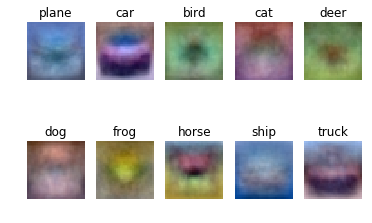

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])